In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
from Bio import SeqIO
from multiprocessing import Pool
from functools import partial
from datetime import datetime

In [2]:
# SETTING
pixel_max = 254 #Customerization

# CHANNEL 0: BASE
base_color_stride = 70 #Customerization
offset_a_g = 40 #Customerization
offset_t_c = 30 #Customerization

# CHANNEL 1: BASE QUALITY
default_quality = 0
base_quality_cap = 40

# CHANNEL 2: MAPPING QUALITY
mapping_set_empty = 255 #Customerization
mapping_quality_cap = 60 #Customerization

# CHANNEL 3: ON POSITIVE STRAND
set_empty = 255 #Customerization
positive_strand = 70 #Customerization
negative_strand = 240 #Customerization

# CHANNEL 4: MATCH REFERENCE
pixel_max = 254 #Customerization
not_match_ref = pixel_max * 1 #Customerization
match_ref = pixel_max * 0.2 #Customerization
ref_not_provided = 255 #Customerization

# TO RGB
pixel_max_empty_def = 255

In [3]:
'''
Color encoding
'''
# CHANNEL 1: Base quality
    
def base_to_color_full_array_input(x):
    A = base_color_stride * 3 + offset_a_g
    T = base_color_stride * 2 + offset_t_c
    C = base_color_stride * 1 + offset_t_c
    G = base_color_stride * 0 + offset_a_g
    empty_to_fill = np.zeros(x.shape, dtype = np.int16)
    empty_to_fill[x == "A"] = A
    empty_to_fill[x == "T"] = T
    empty_to_fill[x == "C"] = C
    empty_to_fill[x == "G"] = G
    empty_to_fill[x == "a"] = A
    empty_to_fill[x == "t"] = T
    empty_to_fill[x == "c"] = C
    empty_to_fill[x == "g"] = G
    empty_to_fill[x == "N"] = 0
    empty_to_fill[x == "D"] = 0
    return empty_to_fill


# CHANNEL 1: Base quality
Quality_Score_Encoding = {"!":0,"\"":1,"#":2,"$":3,"%":4,"&":5,
                          "\'":6,"(":7,")":8,"*":9,"+":10,",":11,
                          "-":12,".":13,"/":14,"0":15,"1":16,"2":17,"3":18,
                         "4":19,"5":20,"6":21,"7":22,"8":23,"9":24,":":25,
                          ";":26,"<":27,"=":28,">":29,"?":30,"@":31,"A":32,
                         "B":33,"C":34,"D":35,"E":36,"F":37,"G":38,"H":39,"I":40}
def base_quality_mapping(x):
    if x in Quality_Score_Encoding.keys():
        quailty = Quality_Score_Encoding[x]
    else:
        quailty = default_quality

# CHANNEL 2: Mapping quality
def mapping_quality_fill(array, mapping_quality):
    
    to_fill = min(mapping_quality, mapping_quality_cap) / mapping_quality_cap * pixel_max
    mapping_quality_temp = np.full(array.shape, mapping_set_empty, dtype = np.int16)
    mapping_quality_temp[array != ""] = to_fill
    mapping_quality_temp[array == "N"] = mapping_set_empty
    mapping_quality_temp[array == "D"] = mapping_set_empty
    
    return mapping_quality_temp
    

# CHANNEL 3: On positive strand
def on_positive_strand_fill(array, positive_flag):
    
    on_positive_strand_temp = np.full(array.shape, set_empty, dtype = np.int16)
    to_fill = positive_strand

    binary_flag = np.binary_repr(positive_flag)
    if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
        to_fill = negative_strand
    
    on_positive_strand_temp[array != ""] = to_fill
    on_positive_strand_temp[array == "N"] = set_empty
    on_positive_strand_temp[array == "D"] = set_empty

    return on_positive_strand_temp


# CHANNEL 4: Match reference
def match_ref_fill(depth, window, array):
    
    empty = np.full((depth, window), ref_not_provided, dtype = np.int16)
    for i in np.arange(0, array.shape[1]):
        for j in np.arange(1, array.shape[0]):
            if array[j,i] == "":
                break
            elif array[j,i] == "N":
                if array[0,i] == "N":
                    break
                else:
                    empty[j,i] = not_match_ref
            elif array[j,i] == array[0,i]:
                empty[j,i] = match_ref
            else:
                empty[j,i] = ref_not_provided
    return empty


# COMBINE CHANNEL TO RGB
def channels_to_RGB(pixel_max_empty_def,
                    pre_image_base_color, 
                    pre_image_mapping_quality, 
                    pre_image_on_positive_strand, 
                    pre_image_match_ref, 
                    use_alpha = False):
    if use_alpha == True: 
        alpha = pre_image_match_ref / pixel_max_empty_def
        pre_image_base_color = np.multiply(pre_image_base_color, alpha)
        pre_image_mapping_quality = np.multiply(pre_image_mapping_quality, alpha)
        pre_image_on_positive_strand = np.multiply(pre_image_on_positive_strand, alpha)

    RGB = np.empty((pre_image_base_color.shape[0],pre_image_base_color.shape[1],pre_image_base_color.shape[2],3), dtype = np.int16)
    RGB[:,:,:,0] = pre_image_base_color
    RGB[:,:,:,1] = pre_image_mapping_quality
    RGB[:,:,:,2] = pre_image_on_positive_strand
    return RGB

In [4]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def make_list_of_searching_interval_of_scaffold(scaffold_length, to_use_selected_scaffold_df):
    mask = np.zeros(scaffold_length, dtype = bool)
    searching_interval_selected = np.arange(1,(scaffold_length + 1))
    searching_locus_list = pd.Series([np.arange(a, b) for a, b in zip(to_use_selected_scaffold_df["expand start"], (to_use_selected_scaffold_df["expand end"] + 1))], to_use_selected_scaffold_df.index)
    for locus in searching_locus_list:
        mask[locus] = True
    searching_interval_unoverlapped = searching_interval_selected[mask]

    return consecutive(searching_interval_unoverlapped)

In [5]:
'''
Preprocessing
'''
def cigar_to_list(cigar): # NOT NEED TO USE THIS! THIS FUNCTION IS INCLUDED IN refine_read_by_cigar BELOW
    '''
    Deal with cigar 
    Split an unsplit cigar list to separated cigar array by number of each condition.
    
    2M3S1D2I to MMSSSDII
    
    Parameters
    ----------
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    cigar_list : 1D numpy array
        A array of cigar.
    '''
        
    separate = np.array([s.strip() for s in re.split(r"(\D+)", cigar)]) # Separate one element cigar list by cigar char 
    if separate[-1] == "": # Delete last empty element if it exists
        separate = separate[:-1]


    number = separate[::2].astype(int) # Extract number of each cigar
    cigar = separate[1::2] # Extract char of cigar

    # Cheack if number of elements in two list are same
    if len(number) != len(cigar): 
        print("elements are not the same")

    # If number of elements are same, make a array of cigar
    else:
        cigar_list = []
        for i in np.arange(0,len(number)):
            for j in np.arange(0,number[i]):
                cigar_list.append(cigar[i])
        cigar_list = np.array(cigar_list)
    
    return cigar_list

def refine_read_by_cigar(read, cigar): #PLEASE USE THIE TO MAKE REFINED READ FOR ALIGNMENT
    '''
    To refine reads by cigar list one by one.
    
    S : Directly delete it and move the behind forward
    I : Extract to make a list of inserted element with position and delete it, moving the behind forward
    D : Fill "D" in reads, move the behind backward
    N : Fill "N" in reads, move the behind backward
    M : Unchange
    
    Parameters
    ----------
    read : list
        One element unseperated read list.
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    refined_read : list
        unseparated list of refined-read
        
    refined_read_insert : 1D numpy array
        the inserted element
    
    refined_read_insert_index_at_ori_read : 1D numpy array
        the index of inserted element in the original read (from 0)
    
    refined_read_insert_index_at_refined_read : 1D numpy array
        the index of where to insert the inserted element on refined read (from 0)
    '''
    cigar_temp_list = cigar_to_list(cigar) # Read cigar and make cigar list by cigar_to_list function
    read_temp_list = np.array(list(read)) # Make list of read

    refined_read = [] # Make empty list for refined read
    ori_read_index = 0 # To keep the original read index for insertion point
    refined_read_index = 0 # To keep index of insertion point on refined read
    refined_read_insert = [] # Make empty list to keep the insertion
    refined_read_insert_index_at_ori_read = [] # FROM 0, make empty list to keep index of insertion on original read
    refined_read_insert_index_at_refined_read = [] #FROM 0, make empty list to keep index of insertion on refined read
    
    # From the first cigar, fill the refined read one by one with original read dependent on the cigar
    ## If cigar(+), ori-read(-):
        ## "D", only refined-index move forward
        ## "N", only refined-index move forward
    ## If cigar(+), ori-read(+): 
        ## "I", only ori-index move forward, but save the information of insertion
        ## "S", only ori-index move forward
        ## "M", two of the index move forward
    for index, cigar in enumerate(cigar_temp_list): 
        if cigar == "S": #Directly ignore it and move the behind forward
            ori_read_index += 1 # Move forward on original index
            continue
        
        if cigar == "H": #Directly ignore it and move the behind forward
            continue
            
        if cigar == "I": #Extract to make a list of inserted element with position and ignore it, moving the behind forward
            refined_read_insert.append(read_temp_list[ori_read_index]) # Save the base
            refined_read_insert_index_at_ori_read.append(ori_read_index) # Save where it is on original read 
            refined_read_insert_index_at_refined_read.append(refined_read_index) # Save where it will be on refined read
            ori_read_index += 1 # Move forward on original index
            continue
            
        if cigar == "D": # Fill "D" in refined read
            refined_read.append("D") # Fill "D"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "N": # Fill "N" in refined read
            refined_read.append("N") # Fill "N"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "M": # Fill the base in refined read
            refined_read.append(read_temp_list[ori_read_index]) # Fill the base
            ori_read_index += 1 # Move forward on original read index
            refined_read_index += 1 # Move forward on refined read index
            continue
            
        else:
            print(cigar,"is not defined at",index) # If there is any exception, print it
            
    refined_read = "".join(refined_read) # Combine list of the base pair 
    refined_read_insert = np.array(refined_read_insert)
    refined_read_insert_index_at_ori_read = np.array(refined_read_insert_index_at_ori_read)
    refined_read_insert_index_at_refined_read = np.array(refined_read_insert_index_at_refined_read)
    return refined_read, refined_read_insert, refined_read_insert_index_at_ori_read, refined_read_insert_index_at_refined_read


def find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df):
    '''
    To find if there is any insertion in the window of one locus, 
    and make dataframes of insertion forward and backward respectively
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    skip range : int
        The range skipped.
    window : int
        The window of one locus.
    read_selected_matrix : numpy array
        2D array that includes the information of reads covering one locus
    to_use_selected_scaffold_df : pandas.DataFrame
        

    Returns
    -------
    forward_df : pandas.DataFrame
        a dataframe saving the information of forward insertion : read, index, base, read order
        
    backward_df : pandas.DataFrame
        a dataframe saving the information of backward insertion : read, index, base, read order
    '''
    forward_i_read = []
    forward_i_index = []
    forward_i_base = []
    forward_i_read_order = [] # FRPM 0 

    backward_i_read = []
    backward_i_index = []
    backward_i_base = []
    backward_i_read_order = [] # FROM 0
    
    # For every read that covers one locus
    for read_order, reads in enumerate(read_selected_matrix[(index - skip_range)]): 
        
        if np.isnan(reads): # Until no read, stop the iteration
            break

        refined_read_i_index = index - to_use_selected_scaffold_df["start"][reads] # To find the index of the locus on one read
        start_insertion_index = refined_read_i_index - ((window - 1) / 2) # To find the start point of one read that would be inside the window
        end_insertion_index = refined_read_i_index + ((window - 1) / 2) - 1 # To find the end point of one read that would be inside the window
        
        # Check every insertion index of one read
        for insertion_index in to_use_selected_scaffold_df["ori insertion index"][reads]:
            if refined_read_i_index <= insertion_index <= end_insertion_index: # If it is after the middle locus but before the end point
                forward_i_read.append(reads) # Add the reads
                forward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                forward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                forward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  

            elif start_insertion_index <= insertion_index <= (refined_read_i_index - 1): # If it is before the middle locus but after the end point
                backward_i_read.append(reads) # Add the reads
                backward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                backward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                backward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  
                
    forward_df = pd.DataFrame({"read": forward_i_read, "index": forward_i_index, "base":forward_i_base, "read order":forward_i_read_order}) # Make the dataframe
    backward_df = pd.DataFrame({"read": backward_i_read, "index": backward_i_index, "base":backward_i_base, "read order":backward_i_read_order}) # Make the dataframe
    
    return forward_df, backward_df


def insertion_fill_in(index, depth, window, pre_image_char_part, forward_df, backward_df):
    '''
    If there is any insertion in the window of one locus,
    insert it and move the other bases forward and backward 
    than delete the exceed
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    depth : int
        The depth.
    window : int
        The window of one locus.
    pre_image_char_part : 2D numpy array
        The 2D array of one locus: pre_image_char_part = pre_image_char[(index - skip_range),:,:]
    forward_df : pandas.DataFrame
        The forward dataframe generated by find_insertion_forbackward function
    backward_df : pandas.DataFrame
        The backward dataframe generated by find_insertion_forbackward function

    Returns
    -------
    pre_image_char_part_output : 2D numpy array
        a new 2D array of one locus to replace the original one
    '''
    # To sort the forward dataframe, ascending order(1->2->3...)
    forward_df = forward_df.sort_values(by = "index", ascending = True)
    
    # To extract read order, index, base from forward dataframe
    for for_read_order, for_index, for_base in zip(forward_df["read order"], forward_df["index"], forward_df["base"]):
        insertion_location = int(for_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[for_read_order + 1] = for_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it
    
    # To sort the backward dataframe, descending order(3->2->1...)
    backward_df = backward_df.sort_values(by = "index", ascending = False)
    
    # To count how many insertion backward for final cutting of the matrix
    cut_length = len(backward_df)
    
    # To extract read order, index, base from backward dataframe
    for back_read_order, back_index, back_base in zip(backward_df["read order"], backward_df["index"], backward_df["base"]):
        insertion_location = int(back_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[back_read_order + 1] = back_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it

    # Cut the required part: if 2 backward insertion and 3 forward insertion with window, extract 2 : 2+window-1    
    pre_image_char_part_output = pre_image_char_part[:,(cut_length):(cut_length + window)]
    
    return pre_image_char_part_output

In [6]:
'''
Read fasta file
'''
def read_fasta(fasta):
    fasta_sequences = SeqIO.parse(open(fasta),"fasta")
    fasta_name = []
    fasta_sequence = []
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        fasta_name.append(name)
        fasta_sequence.append(sequence)
    fasta_dict = {"scaffold":fasta_name,"sequence":fasta_sequence}
    fasta_df = pd.DataFrame(fasta_dict)
    fasta_df["len"] = fasta_df["sequence"].str.len()
    return fasta_df

In [7]:
'''
Read sam file
'''
def read_sam(samfile):
    # Read sam file
    sam=[]
    with open(samfile, "r") as f:
        for line in f.readlines():
            sam.append(line.split("\t"))
    sam = np.array(sam)
    return sam

In [8]:
'''
Scaffold fliter
'''
def scaffold_min_and_max(fasta_df):
    minimum = int(input("Minimum: "))
    maximum = int(input("Maximum: "))
    mask_min = (fasta_df["len"] >= minimum)
    mask_max = (fasta_df["len"] <= maximum)
    fasta_df_fliter = fasta_df[(mask_min & mask_max)]
    if len(fasta_df_fliter) == 0:
        print("There is no scaffold match this length interval")
        return scaffold_min_and_max(fasta_df)
    else:
        print("Number of scaffold: " + str(len(fasta_df_fliter)))
        return fasta_df_fliter, minimum, maximum

In [9]:
'''
For each scaffold, find coveraging read in the sam
'''
def find_read_based_on_scaffold(scaffold_name, sam):
    # Find index of selected scaffold in bam
    scaffold_in_sam = list([i for i,item in enumerate(sam) if scaffold_name in item])

    # Make a DataFrame for selected scaffold information

    selected_scaffold_df = [sam[i] for i in scaffold_in_sam]
    selected_scaffold_df = pd.DataFrame(selected_scaffold_df)
    return selected_scaffold_df

In [10]:
'''
Select useful information in dafaframe of selected scaffold
'''
def make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand = 0):
    scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    
    pd.options.mode.chained_assignment = None
    to_use_selected_scaffold_df_pre = selected_scaffold_df[[1,2,3,4,5,9]]
    to_use_selected_scaffold_df = to_use_selected_scaffold_df_pre[to_use_selected_scaffold_df_pre[9] != "*"]
    to_use_selected_scaffold_df.columns = ["flag","scaffold","start","mapping quality","cigar","read"]
    to_use_selected_scaffold_df["read length"] = to_use_selected_scaffold_df["read"].str.len()
    to_use_selected_scaffold_df["start"] = to_use_selected_scaffold_df["start"].astype('int64')
    to_use_selected_scaffold_df["mapping quality"] = to_use_selected_scaffold_df["mapping quality"].astype('int64')
    to_use_selected_scaffold_df["flag"] = to_use_selected_scaffold_df["flag"].astype('int64')
    to_use_selected_scaffold_df["end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["read length"] - 1)
    to_use_selected_scaffold_df["refined_by_cigar"] = to_use_selected_scaffold_df.apply(lambda x: refine_read_by_cigar(x["read"], x["cigar"]), axis=1)
    to_use_selected_scaffold_df[["refined read", 
                                 "insertion",
                                 "ori insertion index",
                                 "re insertion index"]] = pd.DataFrame(to_use_selected_scaffold_df["refined_by_cigar"].tolist(), index=to_use_selected_scaffold_df.index)
    to_use_selected_scaffold_df.drop(columns=["refined_by_cigar"],inplace=True)
    to_use_selected_scaffold_df["refined read length"] = to_use_selected_scaffold_df["refined read"].str.len()
    to_use_selected_scaffold_df["refined end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["refined read length"] - 1)
    to_use_selected_scaffold_df["expand start"] = (to_use_selected_scaffold_df["start"] - expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand start"] < 1, "expand start"] = 1
    to_use_selected_scaffold_df["expand end"] = (to_use_selected_scaffold_df["refined end"] + expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand end"] > scaffold_length, "expand end"] = scaffold_length
    
    return to_use_selected_scaffold_df

In [11]:
'''
Make a matrix of reads which meet the criteria of each locus
'''
def make_read_selected_matrix_find_reads(to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, depth, ONLY_FILL_THE_LONGEST, index):
    mask1 = to_use_selected_scaffold_df["start"] <= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    mask2 = to_use_selected_scaffold_df["refined end"] >= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    read_selected_array = np.empty(depth)
    read_selected_array[:] = np.nan
    if ONLY_FILL_THE_LONGEST == True:
        if len(to_use_selected_scaffold_df[(mask1 & mask2)]["read length"]) != 0:
            read_selected_array[0:1] = to_use_selected_scaffold_df[(mask1 & mask2)]["read length"].idxmax()
        
    else:
        length = len(to_use_selected_scaffold_df[(mask1 & mask2)].index)
        read_selected_array[0:length] = to_use_selected_scaffold_df[(mask1 & mask2)].index
    
    return read_selected_array

def make_read_selected_matrix(scaffold_name, searching_interval, to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, skip_range, depth, ONLY_FILL_THE_LONGEST, core):
    
    # Interval for searching
    searching_interval_length = len(searching_interval)

    # Search every base that are in this interval
    # And select feasible reads for each base on locus of genome
    if __name__ == "__main__" :  
        
        pool = Pool(core) # Pool() 
        func = partial(make_read_selected_matrix_find_reads, to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, depth, ONLY_FILL_THE_LONGEST)
        read_selected_matrix = pool.map(func, searching_interval) 
        pool.close()  
        pool.join()   
    
    read_selected_matrix = np.array(read_selected_matrix)
        
    return read_selected_matrix

In [12]:
'''
Make a 4 dimension matrix of pre-image base 
'''
def image_pileup_Parallelism(scaffold_name, fasta_df, to_use_selected_scaffold_df, 
                             read_selected_matrix, depth, window, skip_range, 
                             on_positive_strand_not_provide, index, INSERTION = False, 
                             REVERSE_FOR_NEG = True):
    # To search the base based on index
    # From index=0~the last one, means from the first one to the last
    pre_pre_image_char_matrix = np.chararray((depth, window), unicode = True)
    # FIRST!!! FILL ref at depth=0
    # From start point "0" to end point "window - 1" 
    middle = ((window - 1) / 2) # Index not order
    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

    # at "0" fill: (index - middle)
    # at "coverage interval - 1" fill: (index + middle) 
    # This is index of what to fill
    fasta_fill_index_start = (index - middle) # Order not index
    fasta_fill_index_end = (index + middle) # Order not index

    # Set all the element to "N" first
    pre_pre_image_char_matrix[0, :] = "N"
    base_fill_index_start = 0
    base_fill_index_end = window
    if fasta_fill_index_start < 1:
        base_fill_index_start = int(np.abs(fasta_fill_index_start - 1))
        fasta_fill_index_start = 1

    elif fasta_fill_index_end > scaffold_max_length:
        base_fill_index_end = int((scaffold_max_length - fasta_fill_index_end))
        fasta_fill_index_end = scaffold_max_length
    
    pre_pre_image_char_matrix[0, base_fill_index_start:base_fill_index_end] = np.array(list(fasta_df[fasta_df["scaffold"]==scaffold_name]["sequence"].values[0][int(fasta_fill_index_start - 1):int(fasta_fill_index_end)]))   
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break

        else:
            read_start = to_use_selected_scaffold_df["start"][reads] # To find the start point of the read
            read_end = to_use_selected_scaffold_df["refined end"][reads] # To find the end point of the read

            pre_pre_image_char_matrix[(i+1), :] = "N"
            image_read_fill_start = 0
            image_read_fill_end = int(window)
            read_fill_start = int(fasta_fill_index_start - read_start)
            read_fill_end = int(fasta_fill_index_end - read_start) + 1

            if read_start > fasta_fill_index_start:
                image_read_fill_start = int(read_start - fasta_fill_index_start)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][:read_fill_end]))

            elif read_end < fasta_fill_index_end:
                image_read_fill_end = int(read_end - fasta_fill_index_end)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:]))

            else:    
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:read_fill_end]))
    
    ##################### DEAL WITH N #######################################\
    for i in np.arange(0, pre_pre_image_char_matrix.shape[1]): # For all the element in the window
        if pre_pre_image_char_matrix[0, i] == "N": # Check the top element is "N" or not
            A = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "A") # Count "A" 
            T = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "T") # Count "T"
            C = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "C") # Count "C"
            G = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "G") # Count "G"
            N = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "N") # Count "N"

            base_count_list = np.array([A, T, C, G, N]) # Make a list of base
            base_unique_list = np.array(["A", "T", "C", "G", "N"]) # Make a list of index of the base
            base_count_list_sort = np.sort(base_count_list) # Sort the list of base
            if base_count_list_sort[-1] != base_count_list_sort[-2]: # To check if there any duplicated most frequent elements
                pre_pre_image_char_matrix[0, i] == base_unique_list[base_count_list.argmax()] # If no, fill the most frequent one
    
    ####################################### INSERTION #######################################
    if INSERTION == True:
        forward_df, backward_df = find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df)
        if (len(forward_df) != 0) or  (len(backward_df) != 0): # If there is any insertion, use pre_image_char function
            pre_pre_image_char_matrix = insertion_fill_in(index, depth, window, pre_pre_image_char_matrix, forward_df, backward_df)
            
    ####################################### REVERSE STRAND IF ON NEGATIVE STRAND #######################################
    if REVERSE_FOR_NEG == True:
        if pre_pre_image_char_matrix.shape[0] == 2:
            reads = read_selected_matrix[(index - skip_range)][0]
            if not np.isnan(reads):
                positive_flag = to_use_selected_scaffold_df["flag"][reads]
                binary_flag = np.binary_repr(positive_flag)
                if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
                    pre_pre_image_char_matrix = np.flip(pre_pre_image_char_matrix, axis = 1)
                    reverse_temp = pre_pre_image_char_matrix
                    reverse_temp[pre_pre_image_char_matrix == "A"] = "T"
                    reverse_temp[pre_pre_image_char_matrix == "T"] = "A"
                    reverse_temp[pre_pre_image_char_matrix == "C"] = "G"
                    reverse_temp[pre_pre_image_char_matrix == "G"] = "C"
                    pre_pre_image_char_matrix = reverse_temp
        else:
            print("REVERSE_FOR_NEG is only for depth=2")
    
    ####################################### COLOR
    pre_image_base_color = base_to_color_full_array_input(pre_pre_image_char_matrix) 
    
    ####################################### MAPPING QUALITY
    pre_image_mapping_quality_temp = np.full(pre_pre_image_char_matrix.shape, mapping_set_empty)
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break
        else:
            mapping_quality = to_use_selected_scaffold_df["mapping quality"][reads]
            pre_image_mapping_quality_temp[(i + 1), :] = mapping_quality_fill(pre_pre_image_char_matrix[(i+1), :], mapping_quality)
    ####################################### ON POSITIVE STRAND
    on_positive_strand_temp = np.full(pre_pre_image_char_matrix.shape, on_positive_strand_not_provide)
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break
        else:
            positive_flag = to_use_selected_scaffold_df["flag"][reads]
            on_positive_strand_temp[(i + 1), :] = on_positive_strand_fill(pre_pre_image_char_matrix[(i+1), :], positive_flag)
    ####################################### MATCH REF
    pre_image_match_ref_temp = match_ref_fill(depth, window, pre_pre_image_char_matrix)
    
    return pre_image_base_color, pre_image_mapping_quality_temp, on_positive_strand_temp, pre_image_match_ref_temp


def image_pileup(scaffold_name, 
                 fasta_df, 
                 read_selected_matrix, 
                 to_use_selected_scaffold_df, 
                 window, 
                 depth, 
                 skip_range,
                 searching_interval, 
                 pixel_max, 
                 bias_of_read, 
                 mapping_quality_not_provide, 
                 on_positive_strand_not_provide, 
                 not_match_ref, core):
    
    # 3 dimention maxtrix initialization: base(char), base color(int), base quality(char), on postive strand(int)
    ## x: searching_interval 
    ## y: depth
    ## z: coverage read interval
    ####coverage_interval = (length_of_read * 2 -1 + bias_of_read) 
    window = 149
    searching_interval_length = len(searching_interval)

    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    middle = ((window - 1) / 2) # Index not order
    
    # FIRST!!! FILL REF
    # SECOND!!! FILL read at depth=1~
    if __name__ == "__main__" :  
        pre_image_base_color = []
        pre_image_mapping_quality = []
        pre_image_on_positive_strand = []
        pre_image_match_ref = []
        
        
        
        pool = Pool(core) # Pool() 
        func = partial(image_pileup_Parallelism, scaffold_name, fasta_df, to_use_selected_scaffold_df, read_selected_matrix, depth, window, skip_range, on_positive_strand_not_provide)
        for pre_image_base_color_locus, pre_image_mapping_quality_locus, pre_image_on_positive_strand_locus,pre_image_match_ref_locus in pool.map(func, searching_interval, chunksize=1000): 
            pre_image_base_color.append(pre_image_base_color_locus)
            pre_image_mapping_quality.append(pre_image_mapping_quality_locus)
            pre_image_on_positive_strand.append(pre_image_on_positive_strand_locus)
            pre_image_match_ref.append(pre_image_match_ref_locus)
            
        pool.close()  
        pool.join()  
        
    #pre_image_char = np.array(pre_image_char)
    pre_image_base_color = np.array(pre_image_base_color)
    pre_image_mapping_quality = np.array(pre_image_mapping_quality)
    pre_image_on_positive_strand = np.array(pre_image_on_positive_strand)
    pre_image_match_ref = np.array(pre_image_match_ref)
    
 
    return pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref

In [13]:
'''
Visualization of one locus
'''
def visualization_locus(locus, RGB):
    final_plot = RGB
    final_index = locus
    print(final_index)

    plt.figure(figsize=(30,5))
    plt.subplot(4,1,1)
    plt.imshow(final_plot[final_index,:,:,:])
    plt.title("Locus = %s" %locus)
    plt.ylabel("RGB")
    plt.show()

    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(final_plot[final_index,:,:,0],cmap='gray')
    plt.ylabel("Base")
    plt.show()

    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(final_plot[final_index,:,:,1],cmap='gray')
    plt.ylabel("Mapping quality")
    plt.show()

    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(final_plot[final_index,:,:,2],cmap='gray')
    plt.ylabel("On positive strand")
    plt.show()

In [14]:
def consider_only_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED = 0, window =149, depth=10, skip_range=1, ONLY_FILL_THE_LONGEST=False):
    start_time = datetime.now()

    scaffold_image_dict = {}

    total_count = len(fasta_df)

    # For each scaffold 
    for count, scaffold_name in enumerate(fasta_df["scaffold"]):
        start_time_scaffold = datetime.now()
        print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")

        # Select useful information in dafaframe of selected scaffold
        selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

        if len(selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue

        to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name)
        to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus

        # Make a matrix of reads which meet the criteria of each locus
        # Setting
        #ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
        #window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
        #skip_range = 15000 #Customerization # MUST START FROM 1
        #depth = 10 #Customerization
        searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 
        #searching_interval = np.arange(15000,16000)

        print("Step 1: finding reads", end='')

        start_time_temp = datetime.now()
        read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                         searching_interval, 
                                                         to_use_selected_scaffold_df, 
                                                         ALL_TOUCH_INCLUDED, 
                                                         window, skip_range, 
                                                         depth, ONLY_FILL_THE_LONGEST, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        # Make a 3 dimension image
        pixel_max = 254  #Customerization
        bias_of_read = 0 #Customerization
        mapping_quality_not_provide = 255 #Customerization
        on_positive_strand_not_provide = 255 #Customerization
        not_match_ref = pixel_max * 1 #Customerization

        print("Step 2: image pileup", end='')
        start_time_temp = datetime.now()
        pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref = image_pileup(scaffold_name,
                                 fasta_df, 
                                 read_selected_matrix, 
                                 to_use_selected_scaffold_df, 
                                 window, 
                                 depth, 
                                 skip_range,                                                                               
                                 searching_interval, 
                                 pixel_max, 
                                 bias_of_read, 
                                 mapping_quality_not_provide, 
                                 on_positive_strand_not_provide, 
                                 not_match_ref, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        print("Step 3: combination", end='')
        start_time_temp = datetime.now()
        FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                pre_image_base_color, 
                                pre_image_mapping_quality, 
                                pre_image_on_positive_strand, 
                                pre_image_match_ref, 
                                use_alpha = False)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        # Save to dictionary
        print("Step 4: save to dictionary", end='')
        start_time_temp = datetime.now()
        scaffold_image_dict[scaffold_name] = FINAL_RGB
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        end_time_scaffold = datetime.now()
        print("finish ",scaffold_name, end='')
        print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
        print("==========================================")

    print("Final stage: save to pickle")
    # Store data to pickle(serialize)
    save_name = "termite_g2_scaffold_image_dict_" + str(round(minimum/1000)) + "K_" + str(round(maximum/1000)) +"K.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    end_time = datetime.now()
    print("Total duration: {}".format(end_time - start_time))

In [15]:
def consider_read_of_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED = 0, window =149, depth=2, expand = 1000, ONLY_FILL_THE_LONGEST=True):
    start_time = datetime.now()

    scaffold_image_dict = {}

    total_count = len(fasta_df)

    for count, scaffold_name in enumerate(fasta_df["scaffold"]):
        scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
        start_time_scaffold = datetime.now()

        print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")
        print("==================================================================================")

        # Select useful information in dafaframe of selected scaffold
        selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

        if len(selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue

        to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand)
        to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus

        searching_interval_unoverlapped = make_list_of_searching_interval_of_scaffold(scaffold_length, to_use_selected_scaffold_df)

        # Make a matrix of reads which meet the criteria of each locus
        # Setting
        #ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
        #window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
        #skip_range = 1 #Customerization # MUST START FROM 1
        #depth = 2 #Customerization
        ####searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 

        for fragment in searching_interval_unoverlapped:
            searching_interval = fragment
            skip_range = fragment[0] #Customerization # MUST START FROM 1
            start_time_fragment = datetime.now()

            store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1])
            print("Start ",store_name)
            print("Step 1: finding reads", end='')
            start_time_temp = datetime.now()
            read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                             searching_interval, 
                                                             to_use_selected_scaffold_df, 
                                                             ALL_TOUCH_INCLUDED,
                                                             window, skip_range, 
                                                             depth, ONLY_FILL_THE_LONGEST, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            # Make a 3 dimension image
            pixel_max = 254  #Customerization
            bias_of_read = 0 #Customerization
            mapping_quality_not_provide = 255 #Customerization
            on_positive_strand_not_provide = 255 #Customerization
            not_match_ref = pixel_max * 1 #Customerization

            print("Step 2: image pileup", end='')
            start_time_temp = datetime.now()
            pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref = image_pileup(scaffold_name,
                                     fasta_df, 
                                     read_selected_matrix, 
                                     to_use_selected_scaffold_df, 
                                     window, 
                                     depth,
                                     skip_range,
                                     searching_interval, 
                                     pixel_max, 
                                     bias_of_read, 
                                     mapping_quality_not_provide, 
                                     on_positive_strand_not_provide, 
                                     not_match_ref, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            print("Step 3: combination", end='')
            start_time_temp = datetime.now()
            FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                    pre_image_base_color, 
                                    pre_image_mapping_quality, 
                                    pre_image_on_positive_strand, 
                                    pre_image_match_ref, 
                                    use_alpha = False)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            # Save to dictionary
            print("Step 4: save to dictionary", end='')


            start_time_temp = datetime.now()
            scaffold_image_dict[store_name] = FINAL_RGB
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            end_time_fragment = datetime.now()
            print("finish ",store_name, end='')
            print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
            print("==========================================")

        end_time_scaffold = datetime.now()
        print("finish ",scaffold_name, end='')
        print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
        print("==================================================================================")

    print("Final stage: save to pickle")
    # Store data to pickle(serialize)
    save_name = "termite_g2_scaffold_image_dict_" + str(round(minimum/1000)) + "K_" + str(round(maximum/1000)) +"K_fragment.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    end_time = datetime.now()
    print("Total duration: {}".format(end_time - start_time))


In [16]:
def color_encoding_combination(ONLY_CONSIDER_READ = True, ALL_TOUCH_INCLUDED = 0, window =149, depth=2, expand = 1000, core=40):
    fasta_df_ori_name = input("Please enter ref_fasta file: ")
    sam_name = input("Please enter sam file: ")
    
    fasta_df_ori = read_fasta(fasta_df_ori_name)
    sam = read_sam(sam_name)
    
    fasta_df, minimum, maximum = scaffold_min_and_max(fasta_df_ori)
    print("======================================Setting correct====================================")
    if ONLY_CONSIDER_READ == True:
        if depth != 2:
            sys.exit("ERROR! If consider read of scaffold, depth must set to be 2")
        consider_read_of_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED, window, depth, expand)
    else:
        consider_only_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED, window, depth, skip_range=1)

# Part 1: Input
## Input fasta file

In [17]:
# termite_genome2.fasta
# termite_g2.sam

color_encoding_combination(ONLY_CONSIDER_READ = True)

Please enter ref_fasta file: termite_genome2.fasta
Please enter sam file: termite_g2.sam
Minimum: 8000000
Maximum: 9000000
Number of scaffold: 6
======================================Setting correct====================================
Start  NewScaf39  |  1 / 6  |  16.6667 %
Start  NewScaf39|15741 to 24543
Step 1: finding reads | Duration: 0:00:02.810683
Step 2: image pileup | Duration: 0:00:06.668950
Step 3: combination | Duration: 0:00:00.019403
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf39|15741 to 24543 | Duration: 0:00:09.501763
Start  NewScaf39|32330 to 40174
Step 1: finding reads | Duration: 0:00:02.524704
Step 2: image pileup | Duration: 0:00:06.822526
Step 3: combination | Duration: 0:00:00.013818
Step 4: save to dictionary | Duration: 0:00:00.000020
finish  NewScaf39|32330 to 40174 | Duration: 0:00:09.362363
Start  NewScaf39|86621 to 103462
Step 1: finding reads | Duration: 0:00:03.655737
Step 2: image pileup | Duration: 0:00:09.186985
Step 3: combin

Step 2: image pileup | Duration: 0:00:08.825973
Step 3: combination | Duration: 0:00:00.027810
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  NewScaf39|2084830 to 2102086 | Duration: 0:00:14.132298
Start  NewScaf39|2109405 to 2115907
Step 1: finding reads | Duration: 0:00:02.856090
Step 2: image pileup | Duration: 0:00:07.352934
Step 3: combination | Duration: 0:00:00.013851
Step 4: save to dictionary | Duration: 0:00:00.000027
finish  NewScaf39|2109405 to 2115907 | Duration: 0:00:10.224576
Start  NewScaf39|2122531 to 2166593
Step 1: finding reads | Duration: 0:00:11.052736
Step 2: image pileup | Duration: 0:00:18.272084
Step 3: combination | Duration: 0:00:00.081887
Step 4: save to dictionary | Duration: 0:00:00.000017
finish  NewScaf39|2122531 to 2166593 | Duration: 0:00:29.410558
Start  NewScaf39|2173466 to 2178923
Step 1: finding reads | Duration: 0:00:02.637633
Step 2: image pileup | Duration: 0:00:06.801336
Step 3: combination | Duration: 0:00:00.012364
Step 4: sav

Step 2: image pileup | Duration: 0:00:06.501216
Step 3: combination | Duration: 0:00:00.013487
Step 4: save to dictionary | Duration: 0:00:00.000022
finish  NewScaf39|4782239 to 4787581 | Duration: 0:00:09.737183
Start  NewScaf39|4833929 to 4840898
Step 1: finding reads | Duration: 0:00:03.006041
Step 2: image pileup | Duration: 0:00:07.119084
Step 3: combination | Duration: 0:00:00.013098
Step 4: save to dictionary | Duration: 0:00:00.000024
finish  NewScaf39|4833929 to 4840898 | Duration: 0:00:10.141017
Start  NewScaf39|4875015 to 4877256
Step 1: finding reads | Duration: 0:00:02.611254
Step 2: image pileup | Duration: 0:00:06.040237
Step 3: combination | Duration: 0:00:00.003654
Step 4: save to dictionary | Duration: 0:00:00.000024
finish  NewScaf39|4875015 to 4877256 | Duration: 0:00:08.657298
Start  NewScaf39|4881844 to 4927118
Step 1: finding reads | Duration: 0:00:10.065967
Step 2: image pileup | Duration: 0:00:16.323881
Step 3: combination | Duration: 0:00:00.086078
Step 4: sav

Step 1: finding reads | Duration: 0:00:04.678530
Step 2: image pileup | Duration: 0:00:09.494114
Step 3: combination | Duration: 0:00:00.036631
Step 4: save to dictionary | Duration: 0:00:00.000018
finish  NewScaf118|3093506 to 3117481 | Duration: 0:00:14.210884
Start  NewScaf118|3166909 to 3176964
Step 1: finding reads | Duration: 0:00:02.951403
Step 2: image pileup | Duration: 0:00:08.459960
Step 3: combination | Duration: 0:00:00.021935
Step 4: save to dictionary | Duration: 0:00:00.000039
finish  NewScaf118|3166909 to 3176964 | Duration: 0:00:11.438561
Start  NewScaf118|3437227 to 3487759
Step 1: finding reads | Duration: 0:00:12.658213
Step 2: image pileup | Duration: 0:00:17.285788
Step 3: combination | Duration: 0:00:00.085646
Step 4: save to dictionary | Duration: 0:00:00.000019
finish  NewScaf118|3437227 to 3487759 | Duration: 0:00:30.032106
Start  NewScaf118|3519967 to 3531780
Step 1: finding reads | Duration: 0:00:03.357683
Step 2: image pileup | Duration: 0:00:08.358878
Ste

Step 1: finding reads | Duration: 0:00:06.828265
Step 2: image pileup | Duration: 0:00:08.539445
Step 3: combination | Duration: 0:00:00.007845
Step 4: save to dictionary | Duration: 0:00:00.000015
finish  scaffold25|size8808369|3291156 to 3294139 | Duration: 0:00:15.376559
Start  scaffold25|size8808369|3296599 to 3333344
Step 1: finding reads | Duration: 0:00:09.282236
Step 2: image pileup | Duration: 0:00:13.311656
Step 3: combination | Duration: 0:00:00.068011
Step 4: save to dictionary | Duration: 0:00:00.000020
finish  scaffold25|size8808369|3296599 to 3333344 | Duration: 0:00:22.663482
Start  scaffold25|size8808369|4081600 to 4084196
Step 1: finding reads | Duration: 0:00:03.568194
Step 2: image pileup | Duration: 0:00:11.297644
Step 3: combination | Duration: 0:00:00.007750
Step 4: save to dictionary | Duration: 0:00:00.000023
finish  scaffold25|size8808369|4081600 to 4084196 | Duration: 0:00:14.875100
Start  scaffold25|size8808369|4164596 to 4181697
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:03.709333
Step 2: image pileup | Duration: 0:00:09.357938
Step 3: combination | Duration: 0:00:00.018831
Step 4: save to dictionary | Duration: 0:00:00.000028
finish  scaffold25|size8808369|6372172 to 6376584 | Duration: 0:00:13.088361
Start  scaffold25|size8808369|6378588 to 6385095
Step 1: finding reads | Duration: 0:00:04.011007
Step 2: image pileup | Duration: 0:00:09.188548
Step 3: combination | Duration: 0:00:00.014843
Step 4: save to dictionary | Duration: 0:00:00.000027
finish  scaffold25|size8808369|6378588 to 6385095 | Duration: 0:00:13.215987
Start  scaffold25|size8808369|6399388 to 6406350
Step 1: finding reads | Duration: 0:00:03.843658
Step 2: image pileup | Duration: 0:00:08.882689
Step 3: combination | Duration: 0:00:00.013887
Step 4: save to dictionary | Duration: 0:00:00.000020
finish  scaffold25|size8808369|6399388 to 6406350 | Duration: 0:00:12.741685
Start  scaffold25|size8808369|6835250 to 6844323
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:07.693301
Step 2: image pileup | Duration: 0:00:14.492829
Step 3: combination | Duration: 0:00:00.026547
Step 4: save to dictionary | Duration: 0:00:00.000016
finish  scaffold25|size8808369|7955974 to 7969492 | Duration: 0:00:22.214099
Start  scaffold25|size8808369|7989342 to 7998941
Step 1: finding reads | Duration: 0:00:06.502111
Step 2: image pileup | Duration: 0:00:19.302049
Step 3: combination | Duration: 0:00:00.018412
Step 4: save to dictionary | Duration: 0:00:00.000019
finish  scaffold25|size8808369|7989342 to 7998941 | Duration: 0:00:25.825547
Start  scaffold25|size8808369|8081417 to 8085286
Step 1: finding reads | Duration: 0:00:06.809913
Step 2: image pileup | Duration: 0:00:09.891796
Step 3: combination | Duration: 0:00:00.008074
Step 4: save to dictionary | Duration: 0:00:00.000025
finish  scaffold25|size8808369|8081417 to 8085286 | Duration: 0:00:16.712365
Start  scaffold25|size8808369|8101244 to 8127921
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:08.165524
Step 2: image pileup | Duration: 0:00:31.477411
Step 3: combination | Duration: 0:00:00.055792
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  scaffold26|size8476643|3599458 to 3629143 | Duration: 0:00:39.700046
Start  scaffold26|size8476643|3835248 to 3848741
Step 1: finding reads | Duration: 0:00:06.289250
Step 2: image pileup | Duration: 0:00:24.188846
Step 3: combination | Duration: 0:00:00.022714
Step 4: save to dictionary | Duration: 0:00:00.000025
finish  scaffold26|size8476643|3835248 to 3848741 | Duration: 0:00:30.504187
Start  scaffold26|size8476643|3859239 to 3874241
Step 1: finding reads | Duration: 0:00:06.816138
Step 2: image pileup | Duration: 0:00:20.043581
Step 3: combination | Duration: 0:00:00.032157
Step 4: save to dictionary | Duration: 0:00:00.000020
finish  scaffold26|size8476643|3859239 to 3874241 | Duration: 0:00:26.893275
Start  scaffold26|size8476643|3879338 to 3885423
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:07.589052
Step 2: image pileup | Duration: 0:00:14.426970
Step 3: combination | Duration: 0:00:00.011397
Step 4: save to dictionary | Duration: 0:00:00.000016
finish  scaffold26|size8476643|7653818 to 7661675 | Duration: 0:00:22.030054
Start  scaffold26|size8476643|7663848 to 7693595
Step 1: finding reads | Duration: 0:00:10.045163
Step 2: image pileup | Duration: 0:00:46.104370
Step 3: combination | Duration: 0:00:00.055356
Step 4: save to dictionary | Duration: 0:00:00.000024
finish  scaffold26|size8476643|7663848 to 7693595 | Duration: 0:00:56.206391
Start  scaffold26|size8476643|7700816 to 7703893
Step 1: finding reads | Duration: 0:00:07.289988
Step 2: image pileup | Duration: 0:00:10.810287
Step 3: combination | Duration: 0:00:00.010599
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  scaffold26|size8476643|7700816 to 7703893 | Duration: 0:00:18.115311
Start  scaffold26|size8476643|7710279 to 7716356
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:06.988654
Step 2: image pileup | Duration: 0:00:12.905175
Step 3: combination | Duration: 0:00:00.030689
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  scaffold27|size8028190|1202054 to 1210126 | Duration: 0:00:19.926119
Start  scaffold27|size8028190|2409130 to 2475372
Step 1: finding reads | Duration: 0:00:14.074581
Step 2: image pileup | Duration: 0:00:54.824301
Step 3: combination | Duration: 0:00:00.107058
Step 4: save to dictionary | Duration: 0:00:00.000022
finish  scaffold27|size8028190|2409130 to 2475372 | Duration: 0:01:09.007453
Start  scaffold27|size8028190|2570783 to 2573152
Step 1: finding reads | Duration: 0:00:06.880303
Step 2: image pileup | Duration: 0:00:11.401505
Step 3: combination | Duration: 0:00:00.006582
Step 4: save to dictionary | Duration: 0:00:00.000030
finish  scaffold27|size8028190|2570783 to 2573152 | Duration: 0:00:18.290591
Start  scaffold27|size8028190|2596696 to 2688998
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:12.811794
Step 2: image pileup | Duration: 0:00:46.699416
Step 3: combination | Duration: 0:00:00.105856
Step 4: save to dictionary | Duration: 0:00:00.000020
finish  scaffold27|size8028190|4519509 to 4585593 | Duration: 0:00:59.619436
Start  scaffold27|size8028190|4730423 to 4747497
Step 1: finding reads | Duration: 0:00:07.509372
Step 2: image pileup | Duration: 0:00:22.236173
Step 3: combination | Duration: 0:00:00.036020
Step 4: save to dictionary | Duration: 0:00:00.000023
finish  scaffold27|size8028190|4730423 to 4747497 | Duration: 0:00:29.784464
Start  scaffold27|size8028190|4748532 to 4769868
Step 1: finding reads | Duration: 0:00:08.488261
Step 2: image pileup | Duration: 0:00:42.329583
Step 3: combination | Duration: 0:00:00.040271
Step 4: save to dictionary | Duration: 0:00:00.000025
finish  scaffold27|size8028190|4748532 to 4769868 | Duration: 0:00:50.859505
Start  scaffold27|size8028190|4819747 to 4835677
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:07.968615
Step 2: image pileup | Duration: 0:00:13.776126
Step 3: combination | Duration: 0:00:00.008588
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  scaffold27|size8028190|7236098 to 7240585 | Duration: 0:00:21.756006
Start  scaffold27|size8028190|7435903 to 7483394
Step 1: finding reads | Duration: 0:00:11.510354
Step 2: image pileup | Duration: 0:00:41.408940
Step 3: combination | Duration: 0:00:00.088388
Step 4: save to dictionary | Duration: 0:00:00.000022
finish  scaffold27|size8028190|7435903 to 7483394 | Duration: 0:00:53.009197
Start  scaffold27|size8028190|7492744 to 7495671
Step 1: finding reads | Duration: 0:00:08.473654
Step 2: image pileup | Duration: 0:00:14.194778
Step 3: combination | Duration: 0:00:00.009498
Step 4: save to dictionary | Duration: 0:00:00.000026
finish  scaffold27|size8028190|7492744 to 7495671 | Duration: 0:00:22.680438
Start  scaffold27|size8028190|7532150 to 7540028
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:08.224902
Step 2: image pileup | Duration: 0:00:33.646216
Step 3: combination | Duration: 0:00:00.031913
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  scaffold41|size8556100|1543228 to 1564536 | Duration: 0:00:41.904476
Start  scaffold41|size8556100|2415331 to 2423313
Step 1: finding reads | Duration: 0:00:06.988884
Step 2: image pileup | Duration: 0:00:16.739068
Step 3: combination | Duration: 0:00:00.015458
Step 4: save to dictionary | Duration: 0:00:00.000023
finish  scaffold41|size8556100|2415331 to 2423313 | Duration: 0:00:23.745220
Start  scaffold41|size8556100|2441042 to 2476977
Step 1: finding reads | Duration: 0:00:09.307814
Step 2: image pileup | Duration: 0:00:35.095335
Step 3: combination | Duration: 0:00:00.067984
Step 4: save to dictionary | Duration: 0:00:00.000024
finish  scaffold41|size8556100|2441042 to 2476977 | Duration: 0:00:44.472490
Start  scaffold41|size8556100|2516736 to 2520411
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:07.185929
Step 2: image pileup | Duration: 0:00:11.773600
Step 3: combination | Duration: 0:00:00.009775
Step 4: save to dictionary | Duration: 0:00:00.000033
finish  scaffold41|size8556100|3649345 to 3653711 | Duration: 0:00:18.971584
Start  scaffold41|size8556100|3872877 to 3884502
Step 1: finding reads | Duration: 0:00:07.617940
Step 2: image pileup | Duration: 0:00:19.854512
Step 3: combination | Duration: 0:00:00.027696
Step 4: save to dictionary | Duration: 0:00:00.000034
finish  scaffold41|size8556100|3872877 to 3884502 | Duration: 0:00:27.501975
Start  scaffold41|size8556100|3894068 to 3920744
Step 1: finding reads | Duration: 0:00:08.418611
Step 2: image pileup | Duration: 0:00:35.080169
Step 3: combination | Duration: 0:00:00.042100
Step 4: save to dictionary | Duration: 0:00:00.000019
finish  scaffold41|size8556100|3894068 to 3920744 | Duration: 0:00:43.542213
Start  scaffold41|size8556100|3926311 to 3930856
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:07.132225
Step 2: image pileup | Duration: 0:00:15.621478
Step 3: combination | Duration: 0:00:00.041157
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  scaffold41|size8556100|5884494 to 5906024 | Duration: 0:00:22.796182
Start  scaffold41|size8556100|6082820 to 6102104
Step 1: finding reads | Duration: 0:00:06.570885
Step 2: image pileup | Duration: 0:00:13.115872
Step 3: combination | Duration: 0:00:00.036327
Step 4: save to dictionary | Duration: 0:00:00.000027
finish  scaffold41|size8556100|6082820 to 6102104 | Duration: 0:00:19.724390
Start  scaffold41|size8556100|6131447 to 6153904
Step 1: finding reads | Duration: 0:00:06.466644
Step 2: image pileup | Duration: 0:00:14.342863
Step 3: combination | Duration: 0:00:00.042699
Step 4: save to dictionary | Duration: 0:00:00.000026
finish  scaffold41|size8556100|6131447 to 6153904 | Duration: 0:00:20.854285
Start  scaffold41|size8556100|6404495 to 6424027
Step 1: finding reads | Dura

ValueError: could not broadcast input array from shape (144) into shape (145)

# Part 2: Start color encoding
## Version: consider expand of reads on scaffold

In [ ]:
# Store data to pickle(serialize)
with open("termite_g2_scaffold_image_dict_1500K_1550K.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Store data (serialize)
with open("scaffold_image_dict_v1.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# Load data (deserialize)
with open("termite_g2_scaffold_image_dict_1000K_1030K_fragment.pickle", "rb") as handle:
    unserialized_data = pickle.load(handle)

8150


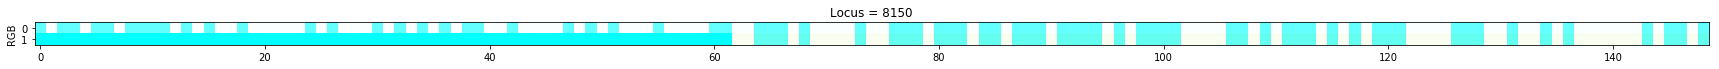

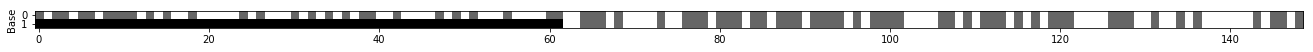

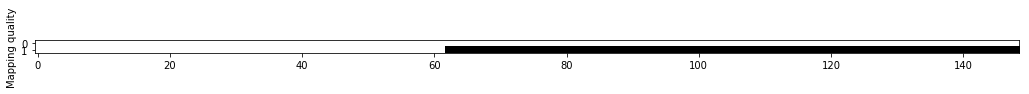

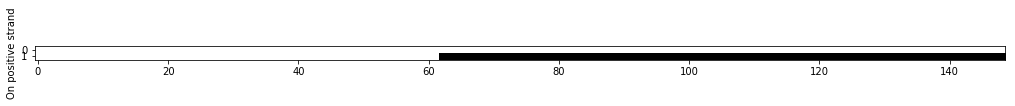

In [20]:
x = unserialized_data['scaffold161|size1025551|543642 to 552805']
visualization_locus(8150, x)